In [21]:
!pip install Sastrawi stopwordsiso

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 7.0 MB/s eta 0:00:00


In [19]:
# ----- 1) Import library -----
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline


In [22]:
# For Indonesian stemming & stopwords
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    import stopwordsiso as stopwordsiso
except Exception as e:
    print("Peringatan: modul Sastrawi/stopwordsiso belum tersedia. Jika di Colab jalankan: !pip install Sastrawi stopwordsiso")
    # fallback: minimal stopwords (ENG) - hasil kurang optimal untuk Bahasa Indonesia
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as fallback_stopwords
    stopwordsiso = None


In [23]:
# ----- 2) Konfigurasi awal & helper -----
RANDOM_STATE = 42
TEXT_COL = None   # biarkan None agar terdeteksi otomatis; bisa diisi "berita" mis. jika ingin paksa
LABEL_COL = None  # biarkan None agar terdeteksi otomatis; bisa diisi "kategori"


In [24]:

# Preprocessing: clean, remove urls, non-alpha, optional stemming
def clean_text(text):
    if pd.isna(text):
        return ""
    s = str(text)
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)  # remove urls
    s = re.sub(r"\S+@\S+", " ", s)  # remove emails
    s = re.sub(r"[^a-z0-9\s]", " ", s)  # keep alphanum and spaces (Bahasa ID includes a-z & digits)
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [25]:
# Load Indonesian stopwords via stopwordsiso if tersedia, else simple fallback list
def get_indonesian_stopwords():
    if stopwordsiso is not None:
        try:
            sw = stopwordsiso.stopwords("id")
            return set(sw)
        except Exception:
            pass
    # fallback small set
    fallback = {
        "yang","dan","di","ke","dari","ini","itu","pada","untuk","dengan",
        "adalah","atau","bahwa","juga","oleh","sebagai","karena","tanpa"
    }
    return fallback

INDO_STOPWORDS = get_indonesian_stopwords()


In [26]:

# Stemmer (Sastrawi) if available
stemmer = None
try:
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
except Exception:
    stemmer = None

def tokenize_and_stem(text, do_stem=True, remove_stopwords=True):
    text = clean_text(text)
    tokens = text.split()
    if remove_stopwords:
        tokens = [t for t in tokens if t not in INDO_STOPWORDS and len(t) > 1]
    if do_stem and (stemmer is not None):
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)


In [27]:
# ----- 3) Load dataset -----
# Ubah path jika perlu
DATA_PATH = "Berita.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File '{DATA_PATH}' tidak ditemukan. Upload Berita.csv ke direktori kerja.")

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
print("Kolom:", df.columns.tolist())

# Auto-detect kolom teks dan label bila belum ditentukan
if TEXT_COL is None:
    text_candidates = ["text","teks","isi","isi_berita","berita","content","artikel"]
    TEXT_COL = None
    for c in df.columns:
        if any(tc in c.lower() for tc in text_candidates):
            TEXT_COL = c
            break
    if TEXT_COL is None:
        # fallback to first object column
        obj_cols = [c for c in df.columns if df[c].dtype == "object"]
        if len(obj_cols) > 0:
            TEXT_COL = obj_cols[0]
        else:
            raise ValueError("Tidak dapat menemukan kolom teks. Silakan set TEXT_COL manual.")

if LABEL_COL is None:
    label_candidates = ["label","kategori","category","class","kelas","target"]
    LABEL_COL = None
    for c in df.columns:
        if any(lc in c.lower() for lc in label_candidates):
            LABEL_COL = c
            break
    if LABEL_COL is None:
        # fallback: choose a column with small unique values
        for c in df.columns:
            if c != TEXT_COL and df[c].nunique() <= 50:
                LABEL_COL = c
                break
    if LABEL_COL is None:
        raise ValueError("Tidak dapat menemukan kolom label. Silakan set LABEL_COL manual.")

print("Menggunakan kolom teks:", TEXT_COL)
print("Menggunakan kolom label:", LABEL_COL)


Dataset shape: (1500, 6)
Kolom: ['No', 'judul', 'berita', 'tanggal', 'kategori', 'link']
Menggunakan kolom teks: berita
Menggunakan kolom label: kategori


In [28]:
# Drop rows where text or label missing
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
print("Setelah dropna shape:", df.shape)

# Show class distribution
print("\nDistribusi kelas:")
print(df[LABEL_COL].value_counts())


Setelah dropna shape: (1500, 6)

Distribusi kelas:
kategori
Ekonomi          375
Olahraga         375
Nasional         375
Internasional    375
Name: count, dtype: int64


In [31]:
from tqdm import tqdm

print("\n🚀 Mulai preprocessing teks (clean -> stopwords -> stemming)...")
df["text_clean"] = df[TEXT_COL].astype(str).apply(clean_text)

processed = []
for i, text in enumerate(tqdm(df["text_clean"], desc="Proses teks", unit="berita")):
    cleaned = tokenize_and_stem(text, do_stem=True, remove_stopwords=True)
    processed.append(cleaned)

    # tampilkan contoh setiap 500 berita
    if (i + 1) % 500 == 0:
        print(f"\n📌 Contoh hasil ke-{i+1}: {cleaned[:150]}...\n")

df["text_proc"] = processed

print("\n✅ Selesai preprocessing!")

# Contoh
print("\n📄 Contoh teks asli -> diproses:")
for i, row in df.head(5).iterrows():
    print(f"- Asli : {row[TEXT_COL][:120]}")
    print(f"  Proses: {row['text_proc'][:120]}\n")



🚀 Mulai preprocessing teks (clean -> stopwords -> stemming)...


Proses teks:  32%|███▏      | 486/1500 [00:22<02:19,  7.29berita/s]


📌 Contoh hasil ke-500: gelandang robi darwis aku percaya persib bandung sempat main timnas indonesia piala aff 2024 asean championship piala aff 2024 debut robi darwis timna...



Proses teks:  67%|██████▋   | 1000/1500 [12:58<13:45,  1.65s/berita]


📌 Contoh hasil ke-1000: badan geologi menteri energi sumber daya mineral esdm tingkat status aktivitas gunung pulau halmahera malu utara siaga awas level iv rabu 15 siang kep...



Proses teks: 100%|██████████| 1500/1500 [22:38<00:00,  1.10berita/s]


📌 Contoh hasil ke-1500: presiden as donald trump salah perintah joe biden tabrak pesawat american airlines helikopter militer black hawk konferensi pers kamis 30 beber bukti ...


✅ Selesai preprocessing!

📄 Contoh teks asli -> diproses:
- Asli : Menteri Koordinator (Menko) Bidang Perekonomian Airlangga Hartarto berharap kenaikan upah minimum provinsi (UMP) sebesar
  Proses: menteri koordinator menko bidang ekonomi airlangga hartarto harap naik upah minimum provinsi ump persen 2025 tingkat day

- Asli : Dalam rangka memeriahkan hari jadi ke-50, PT Surabaya Industrial Estate Rungkut (PT SIER) menggelar acara bertajuk Green
  Proses: rangka riah 50 pt surabaya industrial estate rungkut pt sier gelar acara tajuk green industrial awards sier customer gat

- Asli : Wacana Presiden Prabowo Subianto akan membentuk akan membentuk Kementerian Penerimaan Negara kembali santer beredar.Siny
  Proses: wacana presiden prabowo subianto bentuk bentuk menteri terima negara santer edar sinyal bentuk no

In [32]:
# ----- 5) Feature extraction untuk LDA (CountVectorizer) -----
# Pakai CountVectorizer karena LDA bekerja dengan counts
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=4000)
X_counts = vectorizer.fit_transform(df["text_proc"])


In [33]:

# ----- 6) Latent Dirichlet Allocation (LDA) -----
lda = LatentDirichletAllocation(n_components=n_topics, random_state=RANDOM_STATE, learning_method="batch", max_iter=20)
topic_distributions = lda.fit_transform(X_counts)  # shape (n_docs, n_topics)

# Fungsi tampilkan kata topik
def show_top_words(model, feature_names, n_top_words=12):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        words = [feature_names[i] for i in top_indices]
        topics.append(words)
        print(f"Topik {topic_idx}: {', '.join(words)}")
    return topics

feature_names = vectorizer.get_feature_names_out()
topics_words = show_top_words(lda, feature_names, n_top_words=12)

# Tambahkan distribusi topik ke dataframe
topic_cols = [f"topic_{i}" for i in range(topic_distributions.shape[1])]
df_topics = pd.DataFrame(topic_distributions, columns=topic_cols)
df_with_topics = pd.concat([df.reset_index(drop=True), df_topics.reset_index(drop=True)], axis=1)


Topik 0: makan, gizi, red, program, sparks, mbg, megawati, gratis, mobil, anak, pink, metro
Topik 1: korban, polisi, laku, duga, rumah, keluarga, anak, orang, tembak, sakit, temu, warga
Topik 2: israel, presiden, senjata, gaza, gencat, hamas, perintah, palestina, serang, yoon, menteri, militer
Topik 3: indonesia, negara, china, brics, as, hendra, malaysia, ahsan, anggota, trump, 20, negeri
Topik 4: persen, menteri, prabowo, perintah, indonesia, harga, 2025, 12, kerja, ppn, uang, juta
Topik 5: jalan, banjir, jakarta, kota, 2024, warga, air, camat, kabupaten, 2025, desa, masyarakat
Topik 6: bakar, pesawat, orang, los, angeles, api, air, as, celaka, sebab, terbang, tumpang
Topik 7: main, gol, menit, menang, laga, vietnam, liga, tanding, aff, gawang, piala, hasil
Topik 8: indonesia, timnas, main, latih, piala, dunia, tim, kluivert, pssi, pilih, gambas, shin
Topik 9: laut, pagar, kpk, menteri, tangerang, hukum, milik, sangka, duga, nelayan, kait, korupsi


In [34]:
# ----- 7) Siapkan data latih dan uji -----
le = LabelEncoder()
df_with_topics["label_enc"] = le.fit_transform(df_with_topics[LABEL_COL].astype(str))
print("\nLabel classes:", list(le.classes_))

X = df_with_topics[topic_cols].values   # fitur: distribusi topik
y = df_with_topics["label_enc"].values



Label classes: ['Ekonomi', 'Internasional', 'Nasional', 'Olahraga']


In [35]:

# Stratified split supaya distribusi kelas terjaga
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df_with_topics.index.values, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")


Train size: 1200 | Test size: 300


In [37]:
# ----- 8) Train model: MultinomialNB & LinearSVC -----
# Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_nb = mnb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

# Linear SVM
svm = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)

print("\nAkurasi (Test):")
print(f"- MultinomialNB: {acc_nb:.4f}")
print(f"- LinearSVC    : {acc_svm:.4f}")




Akurasi (Test):
- MultinomialNB: 0.8867
- LinearSVC    : 0.8867


In [38]:
# ----- 9) Evaluasi detail -----
print("\n=== Classification Report - MultinomialNB ===")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_, zero_division=0))

print("\n=== Classification Report - LinearSVC ===")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

# Confusion matrices
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_svm = confusion_matrix(y_test, y_pred_svm)



=== Classification Report - MultinomialNB ===
               precision    recall  f1-score   support

      Ekonomi       0.87      0.83      0.85        75
Internasional       0.90      0.93      0.92        75
     Nasional       0.78      0.79      0.78        75
     Olahraga       1.00      1.00      1.00        75

     accuracy                           0.89       300
    macro avg       0.89      0.89      0.89       300
 weighted avg       0.89      0.89      0.89       300


=== Classification Report - LinearSVC ===
               precision    recall  f1-score   support

      Ekonomi       0.88      0.85      0.86        75
Internasional       0.88      0.93      0.90        75
     Nasional       0.79      0.76      0.78        75
     Olahraga       1.00      1.00      1.00        75

     accuracy                           0.89       300
    macro avg       0.89      0.89      0.89       300
 weighted avg       0.89      0.89      0.89       300



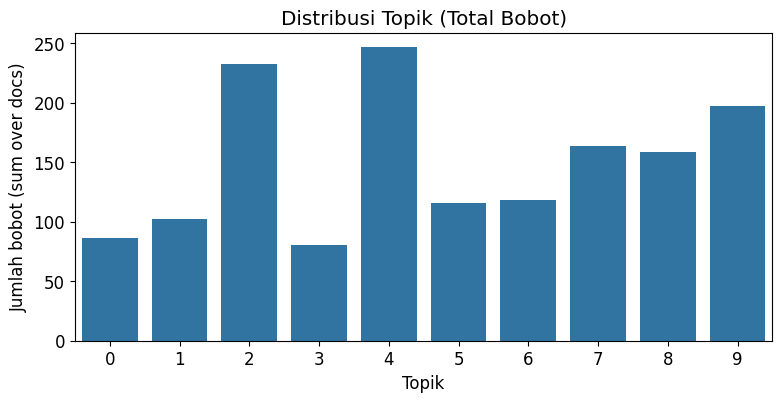

In [39]:
# ----- 10) Visualisasi -----
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# a) Distribusi topik (total bobot tiap topik)
topic_sums = topic_distributions.sum(axis=0)
plt.figure(figsize=(9,4))
sns.barplot(x=np.arange(len(topic_sums)), y=topic_sums)
plt.xlabel("Topik")
plt.ylabel("Jumlah bobot (sum over docs)")
plt.title("Distribusi Topik (Total Bobot)")
plt.show()


Text(116.72222222222221, 0.5, 'Actual')

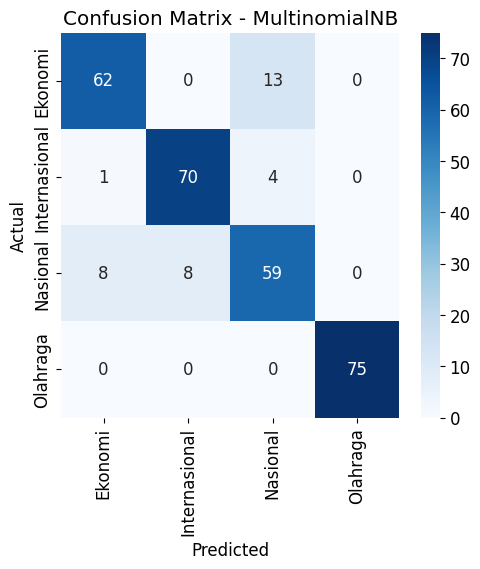

In [43]:
# b) Confusion matrices (NB & SVM)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - MultinomialNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")



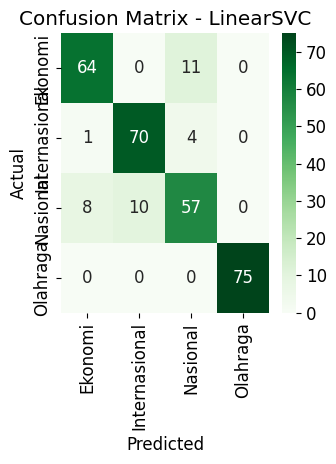

In [42]:

plt.subplot(1,2,2)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - LinearSVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


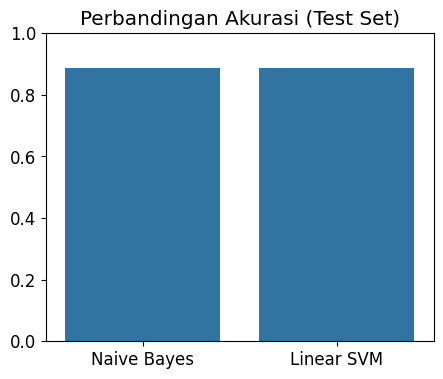

In [44]:

# c) Perbandingan akurasi
plt.figure(figsize=(5,4))
sns.barplot(x=["Naive Bayes","Linear SVM"], y=[acc_nb, acc_svm])
plt.ylim(0,1)
plt.title("Perbandingan Akurasi (Test Set)")
plt.show()


In [54]:
# ----- d) Visualisasi beberapa dokumen & topik dominan -----
n_show = 6
sample_idx = idx_test[:n_show]

print("\nContoh dokumen test + topik dominan:")

for i in sample_idx:
    txt = df_with_topics.loc[i, TEXT_COL]

    # pastikan hasilnya array 1D float, bukan object atau float tunggal
    topic_vec = np.array(df_with_topics.loc[i, topic_cols], dtype=float)

    # ambil topik dominan
    dom_topic = int(np.argmax(topic_vec))

    print(f"- Index {i} | Label: {df_with_topics.loc[i, LABEL_COL]} | TopikDominan: {dom_topic}")
    print("  Teks (potong):", txt[:220].replace("\n", " "))

    # pastikan distribusi topik bisa diurutkan & dibulatkan tanpa error
    top5 = np.sort(topic_vec)[-5:][::-1]
    print("  Distribusi topik (top5):", np.round(top5, 3))

    # tampilkan kata kunci topik dominan
    if dom_topic < len(topics_words):
        print("  Kata topik dominan:", topics_words[dom_topic][:10])
    else:
        print("  Kata topik dominan: [Topik tidak ditemukan]")

    print("")



Contoh dokumen test + topik dominan:
- Index 1435 | Label: Internasional | TopikDominan: 2
  Teks (potong): Aksi Elon Musk yang membuat isyarat tangan mirip salam Nazi saat pelantikan Donald Trump sebagai Presiden Amerika Serikat, menuai kecaman media Israel.Gerakan tangan miliarder penyumbang dana kampanye terbesar Trump dala
  Distribusi topik (top5): [0.733 0.206 0.029 0.027 0.001]
  Kata topik dominan: ['israel', 'presiden', 'senjata', 'gaza', 'gencat', 'hamas', 'perintah', 'palestina', 'serang', 'yoon']

- Index 1172 | Label: Internasional | TopikDominan: 2
  Teks (potong): Ibu negara Korea Selatan sekaligus istri Presiden Yoon Suk Yeol, Kim Keon Hee, disebut meminta agar ketua partai berkuasa People Power Party (PPP), Han Dong Hoon dilengserkan.Wakil sekretaris jenderal perencanaan strateg
  Distribusi topik (top5): [0.945 0.051 0.    0.    0.   ]
  Kata topik dominan: ['israel', 'presiden', 'senjata', 'gaza', 'gencat', 'hamas', 'perintah', 'palestina', 'serang', 'yoon']

- Inde

In [55]:

# ----- 11) Simpan dataset berfitur topik & model bila perlu -----
# Simpan CSV fitur topik + label encoding
out_csv = "berita_topic_features.csv"
cols_to_save = [TEXT_COL, LABEL_COL, "label_enc"] + topic_cols
df_with_topics[cols_to_save].to_csv(out_csv, index=False)
print("Saved topic-feature CSV:", out_csv)


Saved topic-feature CSV: berita_topic_features.csv
